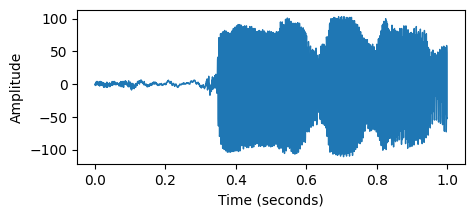

(2000,) -111 103
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32016     
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 32186 (125.73 KB)
Trainable params: 32186 (125.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [256]:
import librosa
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io import savemat
import keras
import tensorflow as tf


SAMPLE_RATE = 2000


def load_waveform(file_path):
    signal, _ = librosa.load(
        path=file_path,
        sr=SAMPLE_RATE,
        mono=True,
        offset=0.0,
        duration=1.0,
        dtype=np.float32, # original: 16-bit audio
        res_type='soxr_hq' # see docs for librosa.resample
    )
    signal = librosa.mu_compress(signal, mu=255)
    return signal


def plot_waveform(signal):
    num_samples = len(signal)
    time_axis = np.arange(0, num_samples) / SAMPLE_RATE

    plt.figure(figsize=(5,2))
    plt.plot(time_axis, signal, linewidth=1)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


def load_mag_db_spectrogram(file_path):
    signal = load_waveform(file_path)
    stft = librosa.stft(signal, n_fft=256, hop_length=125)
    magnitude, _ = librosa.magphase(stft)
    db_spec = librosa.amplitude_to_db(magnitude)
    return db_spec


def load_cqt_features(file_path):
    signal = load_waveform(file_path)
    cqt = librosa.cqt(signal, sr=SAMPLE_RATE, hop_length=125, n_bins=84)
    return np.abs(cqt)


#sample_file = '/home/cameron/voice_data/LibriSpeech/train-clean-100/211/122425/211-122425-0019.flac'
#sample_file = '/home/cameron/voice_data/LibriSpeech/train-clean-100/4014/186179/4014-186179-0015.flac'
#robust_file = '/home/cameron/voice_data/LibriSpeech/train-clean-100/4195/186237/4195-186237-0005.flac'
not_robust_file = '/home/cameron/voice_data/LibriSpeech/train-clean-100/4195/186237/4195-186237-0008.flac'

display(Audio(not_robust_file))

signal = load_waveform(not_robust_file)
plot_waveform(signal)
print(signal.shape, min(signal), max(signal))
signal = signal.reshape(1, 2000)

model_save_dir = '../saved_models/mlp_dense16_mu_compress_rate_2kHz'
model = keras.models.load_model(model_save_dir)
model.summary()

In [257]:
# attack with FGSM
# https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

loss_object = keras.losses.CategoricalCrossentropy()

def create_adversarial_waveform(input_audio, input_label, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(input_audio)
        prediction = model(input_audio)
        loss = loss_object(input_label, prediction)
    
    gradient = tape.gradient(loss, input_audio)
    sign_grad = tf.sign(gradient)
    return epsilon * sign_grad

In [258]:
signal = tf.convert_to_tensor(signal)
signal = tf.cast(signal, tf.float32)

pred_labels = model.predict(signal)
original_pred_label = np.argmax(pred_labels)
print(pred_labels)

label = tf.one_hot(3, 10)
label = tf.reshape(label, [1, 10])
print(signal.shape, label.shape)

perturbation = create_adversarial_waveform(signal, label, 0.26)
print(perturbation.shape)

adversarial_audio = perturbation + signal
adv_y_pred = model.predict(adversarial_audio)
adv_pred_label = tf.argmax(adv_y_pred[0])
print(adv_y_pred.shape, adv_y_pred)

print(f'original label = {original_pred_label}')
print(f'adversarial label = {adv_pred_label}')

#plot_waveform(perturbation[0])

1/1 [==============================] - 0s 33ms/step


[[6.8920973e-19 1.1585503e-17 4.5557030e-30 9.9999189e-01 8.1406397e-06
  0.0000000e+00 2.1605396e-16 4.6639205e-28 7.6545283e-14 5.7832921e-13]]
(1, 2000) (1, 10)
(1, 2000)
1/1 [==============================] - 0s 14ms/step
(1, 10) [[1.1376918e-14 4.2237008e-18 6.4306782e-25 4.3781412e-01 5.6218588e-01
  1.3669330e-38 1.4220543e-13 1.7305534e-28 1.3515515e-12 8.5879046e-09]]
original label = 3
adversarial label = 4


(1, 2000) (1, 2000)


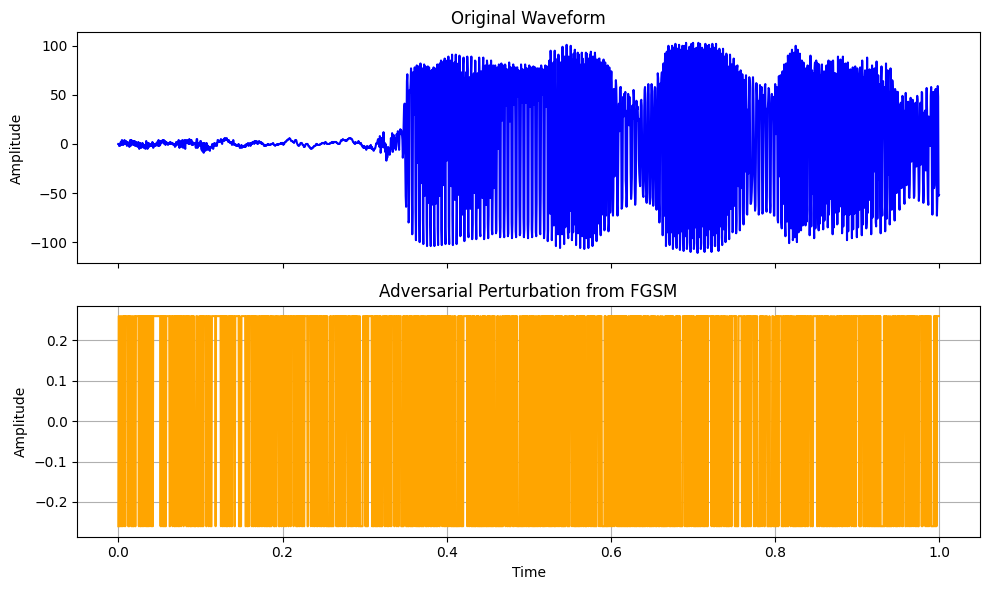

In [259]:
# Plot the original waveform and the noisy waveform

# def plot_waveform(signal):
    
    

#     plt.figure(figsize=(5,2))
#     plt.plot(time_axis, signal, linewidth=1)
#     plt.xlabel("Time (seconds)")
#     plt.ylabel("Amplitude")
#     plt.show()

print(signal.shape, adversarial_audio.shape)
signal = np.squeeze(signal)
adversarial_audio = np.squeeze(adversarial_audio)
perturbation = np.squeeze(perturbation)
num_samples = len(signal)
time_axis = np.arange(0, num_samples) / SAMPLE_RATE

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(time_axis, signal, color='blue')
ax1.set_ylabel('Amplitude')
ax1.set_title('Original Waveform')

ax2.plot(time_axis, perturbation, color='orange')
ax2.set_ylabel('Amplitude')
ax2.set_title('Adversarial Perturbation from FGSM')

plt.xlabel('Time')
plt.tight_layout()
plt.grid(True)
plt.show()

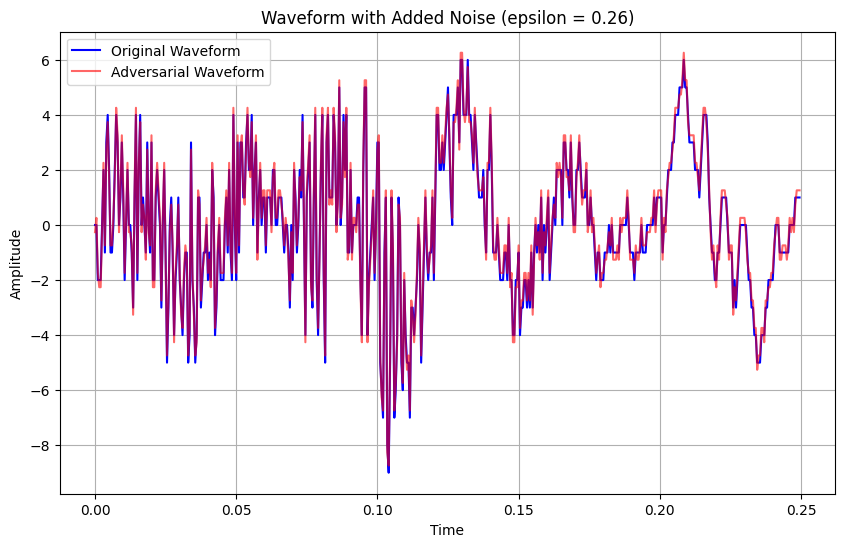

In [260]:
plt.figure(figsize=(10, 6))
t = time_axis[:500]
plt.plot(t, signal[:500], label='Original Waveform', color='blue')
plt.plot(t, adversarial_audio[:500], label='Adversarial Waveform', color='red', alpha=0.6)
plt.title('Waveform with Added Noise (epsilon = 0.26)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# plt.title('Waveform and Adversarial Example')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()

In [263]:
signal2 = load_waveform(not_robust_file)

Save training data to disk

In [261]:
# train_list = '../data_lists/libri100_train.txt'
# with open(train_list, 'r') as f:
#     all_lines = f.readlines()

# for i, line in enumerate(all_lines):
#     file_path = line.strip().split(' ')[-1]

#     signal = load_waveform(file_path)
#     mel_spec = load_mel_spectrogram(file_path)
    
#     tmp = file_path.split('.')[0]
#     save_path = f'{tmp}_mel_spec.mat'
#     #savemat(save_path, {'mel_spec': mel_spec})

#     if i < 5: print(file_path, mel_spec.shape)

In [262]:
# new_sr = 44100
# signal = librosa.resample(y=signal, orig_sr=SAMPLE_RATE, target_sr=new_sr)
# # sf.write('downsampled.flac', signal, SAMPLE_RATE, subtype='PCM_24', format='flac')

# display(Audio(signal, rate=new_sr))
# plot_waveform(signal)

# def load_mel_spectrogram(file_path):
#     signal, _ = librosa.load(
#         path=file_path,
#         sr=16000,
#         mono=True,
#         offset=0.0,
#         duration=1.0,
#         dtype=np.float32,
#         res_type='soxr_hq' # see docs for librosa.resample
#     )
#     mel_spec = librosa.feature.melspectrogram(
#         y=signal,
#         sr=16000,
#         n_fft=512,
#         hop_length=128,
#         n_mels=128
#     )

#     min_val = np.min(mel_spec)
#     max_val = np.max(mel_spec)
#     mel_spec = (mel_spec - min_val) / (max_val - min_val)
#     mel_spec *= 255
#     mel_spec = np.rint(mel_spec) - 128

#     return mel_spec

# mel_spec = load_mel_spectrogram(sample_file)
# print(mel_spec.shape)
# plt.imshow(mel_spec)

#savemat('label5.mat', {'signal': signal})

# mel_spec = load_mag_db_spectrogram(sample_file)
# print(mel_spec.shape, mel_spec.dtype)

#flat_stft = mel_spec.flatten()
#print(min(flat_stft), max(flat_stft))
#flat_stft

# plt.imshow(mel_spec)

# cqt = load_cqt_features(sample_file)
# plt.imshow(cqt)